## WaveNet 

2016年，DeepMind团队提出了WaveNet深度学习模型，可以根据之前的样本和一些声学参数(eg.频谱)，一次预测一个样本。理解WaveNet以及相似架构的一个关键点是网络不直接输出样本值。相反，输出的是下一个样本值的概率分布。根据这个分布，通过一个采样步骤生成随机值作为下一个样本值。然后将新的样本值反馈到网络中以便于接下来的值与之前所有的决策一致。那么为什么我们不直接选择最可能的值作为下一个样本值呢？因为语音本质上是随机的。最好的例子是‘s’的发音，它本质上高斯分布的随机噪声。如果我们为每个样本选择最可能的值，我们将全部生成0，因为每个样本为正值和负值的可能性是一样的。事实上尽管元音比清音随机性小，但所有的音素都有一定的随机性，这就是为什么我们需要这种采样操作的原因。

Wavenet模型可以根据一个序列的前 t-1 个点预测第 t 个点的结果，因此可以用来预测语音中的采样点数值。生成我们当前的音频信号也可以基于先前的音频。基本公式如下：

$$p(x)=\prod_{t=1}^T p(x_t|x_1,\cdots,x_{t-1})$$

### 1. Dilated Convolution

在该模型中，我们使用softmax层作为输出层，把采样值的预测作为分类任务进行。Dilated Casual Convolutions

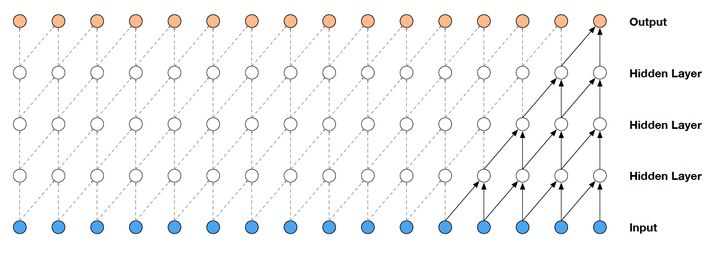

WaveNet的基本结构如上图所示，蓝色的input表示一个个的音频信号采样点，使用一个叠层的一维卷积（也称为因果卷积casual convolutional layers）来进行表示。这个一维卷积的宽度为2，卷积每次移动的步长为1。如下图所示，在这种配置下，我们叠层四次的感受野为5个点.

在这种条件下如果要提高我们的感受野，那么我们需要增加额外的层数，最终导致的结果是，我们需要花费巨额的计算量。

为了减少计算量和提高感受野，论文中使用了膨胀因果卷积（dilated casual convolutional layer）。

简单说来，就是将卷积每次移动的步长设置为了2。这样子就会导致每次的卷积不会有重叠的部分。

如下图2.2所示，计算量上与图2.1保持一致，但是感受野从5个点扩张到16个点。

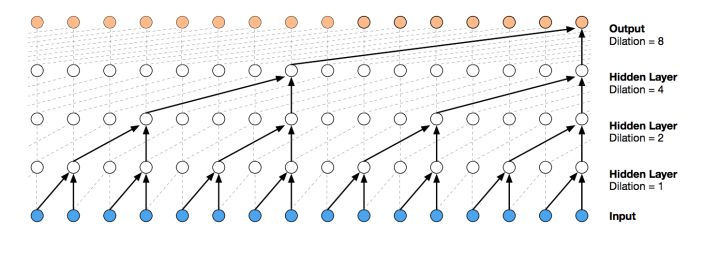

Wavenet模型主要成分是这种卷积网络，每个卷积层都对前一层进行卷积，卷积核越大，层数越多，时域上的感知能力越强，感知范围越大。在生成过程中，每生成一个点，把该点放到输入层最后一个点继续迭代生成即可。

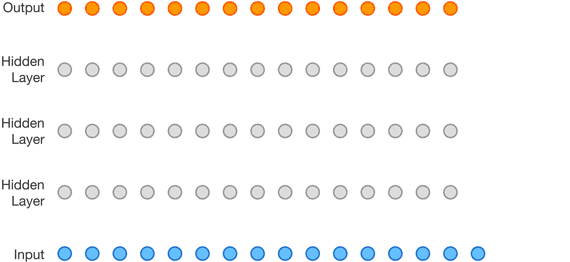

### 2. Softmax Distribution

Wavenet在输出层使用了softmax，求取每个采样点的概率。由于16位的采样点就有65536种采样结果，所以我们使用 $\mu-law$ 法则来重新量化这个原始音频，对采样值进行转换。其公式如下：

$$f(x_t)=sign(x_t)\frac{\text{ln}(1+\mu |x_t|)}{\text{ln}(1+\mu)}$$

转换后，65536个采样值会转换成256个值，通过降低维度，很大程度上能够降低最后一层的映射和 softmax 层的计算量。使用这种算法会对一些不常见的高频部分进行压缩，降低了量化精度并将损失尽可能减少。使用了这种非线性量化后的网络重构质量能够提高，尤其对于语音信号而言，这种损失相对较小，可以获得比较理想的结果。

### 门控卷积

通过一个膨胀门卷积操作之后，使用了一个门控卷积进行门控控制。

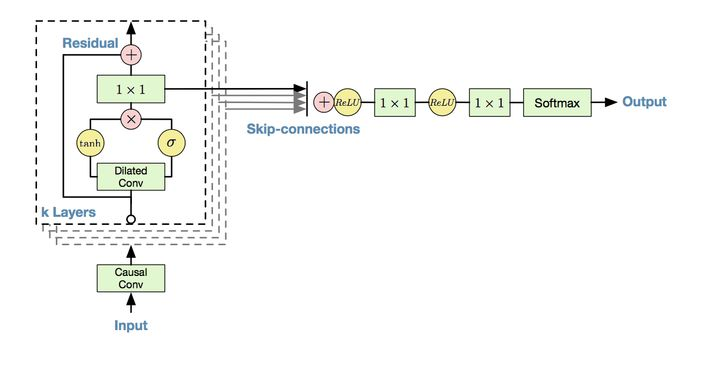

门控卷积表达式为 $z=tanh(W_{f,k}*x)\odot \sigma(W_{g,k} * x)$ 其中 * 表示卷积操作，$\odot$ 为对应位置相乘运算符。加入Residual的短路结构，来更好的进行训练。

最后的结果是根据每一层的输出的中间结果进行叠加（Skip-connections）后得到。

WaveNet可以合成质量比其他声码器高得多的音频，但他有一个缺点：复杂性。合成语音需要每秒数百亿次浮点运算(GFLOPS。这对于在CPU上运行来说太高了，但是GPU能够实现TFLOPS范围内的性能，所以没问题，对吧？嗯并不完全对。GPU非常擅长并行执行大量操作，但他们在WaveNet上效率不是很高，原因是为了获得足够大的感受野卷积层做得太深太复杂

## WaveRNN

WaveRNN解决了上面的问题1.它没有使用一堆卷积。而是使用了可以在更少步骤中计算的RNN。使用带有稀疏矩阵的RNN也降低了复杂度，以便于我们可以将它在CPU上实现。话虽如此，但它的复杂度仍然在10GFLOPS左右，比典型的语音处理算法高出两个数量级

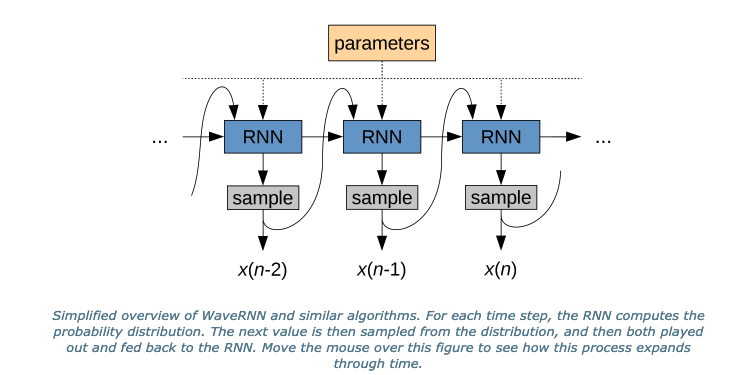

waveRNN使用三种先进的计算方法来提高生成语音的质量。它的模型很小。

论文有三个创新点。

1. 本文提出了一种单层RNN网络架构，使用dual softmax layer去达到目前最好的语音生成水平，可以实时生成 24kHz,16-bit语音。

2. 本文使用权重剪枝技术实现96%的稀疏度。

3. 本文提出了一种高度并行化的语音生成算法。在语音生成中，生成一个很长的序列并将其折叠成几个短序列，这几个短序列都是同时生成的，因此提高生成长序列的速度(将长序列折叠成一批较短的序列，并允许一次生成多个样本)

下面将一一介绍每个创新点。首先分析语音生成的效率，然后根据语音效率的分析，本文一一提出了优化。

### 语音生成效率分析

对于序列生成模型，其生成速度可以用下式来表示。

$$T(u)=|u|\sum_{i=1}^N(c(op_i)+d(op_i))$$

$T(u)$ 是生成某个句子u 发音所需的时间。总共有|u| 个样本，这里的样本和数字音频中的样本是一个意思。对于高质量的声音|u|是非常大的。例如，高保真声音是24k个样本，每个样本对应16bits. N表示神经网络的层数。如果网络有很多层，则N可能非常大。$c(op)$ 代表每一层计算的时间。如果网络很宽或有很多kernels，那么计算时间就会很长。$d(op)$ 表示硬件执行程序的开销时间，包括调用程序和提取相应参数的时间。为了快速生成语音，上述每个参数都应尽可能小。

上面的式子为我们提升效率提供了线索，我们可以通过：(1)降低模型的计算数量(减少N)，(2)选择更适合GPU计算的operation(减少d)，(3)减少权重数量(减少c)，(4)同时生成多个token(减少序列长度)等方法来减少计算时间。

### WaveRNN architecture

wavernn主要包括一个GRU，两层全连接，还有一层softmax。输入是上一帧语音 $s_{t-1}$ ，conditioning parameter $f$,输出离散的概率分布$P_{s_t}$,16bit model: 8bit粗划分，8bit细划分

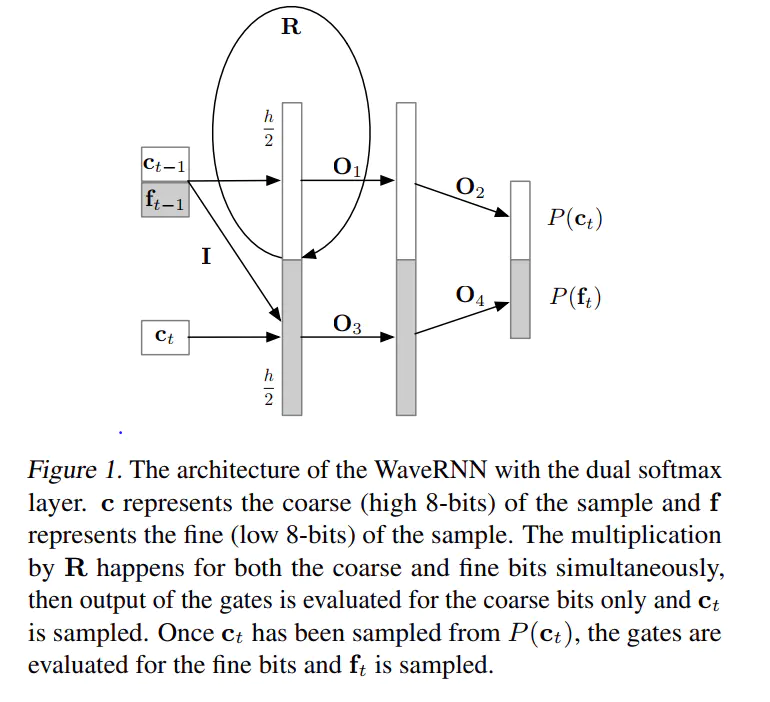

WaveRNN有两个softmax layer. Coarse 8 represents rough 8bit. 可以理解为最重要的8 bits(8 MSB).R层是一个GRU层，会先用来生成coarse 8 bits(粗8bits),生成粗8bits后作为输入生成 fine 8 bits(细8bits)

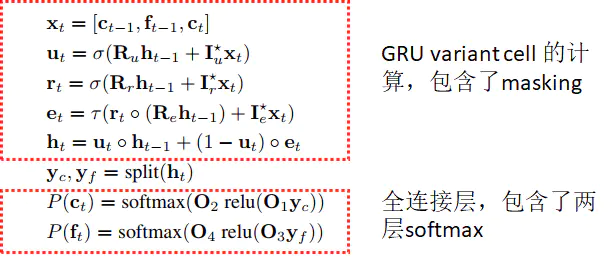

我们先看一下公式，如上图所示 $c_{t-1}$, $f_{t-1}$分别表示t-1时coarse 8bits和fine 8 bits的输出。注意上图的softmax计算可以知道网络的输出是 $c_t$,$f_t$. 计算 $u_t$时有个*，用来表示掩码矩阵。掩码矩阵主要用于计算粗8bits，因为 $x_t$ 的输入中有一个 $c_t$,还没有生成，所以需要使用掩码矩阵把这部分设为0来计算。其中粗细部分均在[0,255]之间，对应softmax 的 256个类型。粗细部分放一起就是对应声音的16bits.

由于我们要生成16bit sequence，因此每个token都要生成16个bit，但是如果直接使用softmax则会有2^16个标签，因此作者把16bit分成两个部分，coarse和fine，即公式中的c和f，coarse是high 8-bit，fine是low 8-bit，这样就把输出空间缩小到2^8=256个值上。

如果你还是不懂这两个阶段的生成过程，下图详细讲解。

粗8bits生成的示意图：

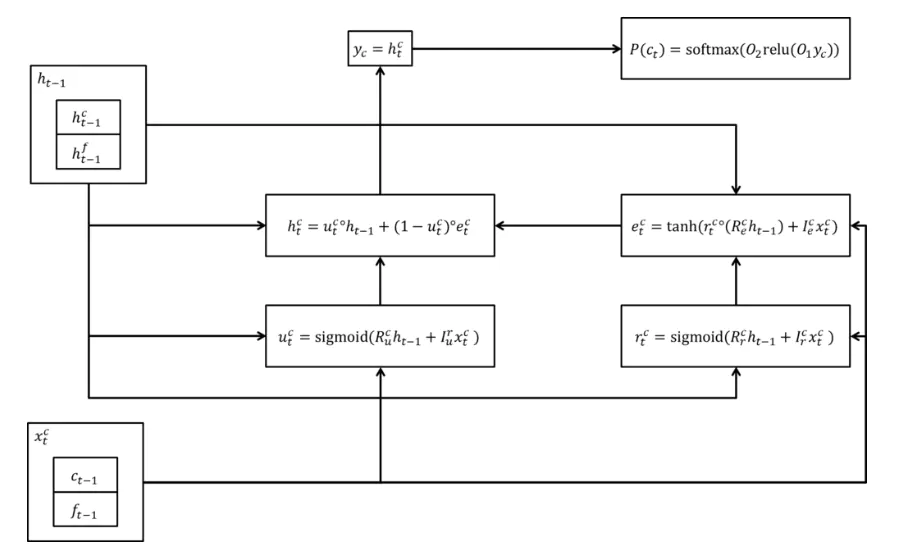

细8bits生成的示意图：

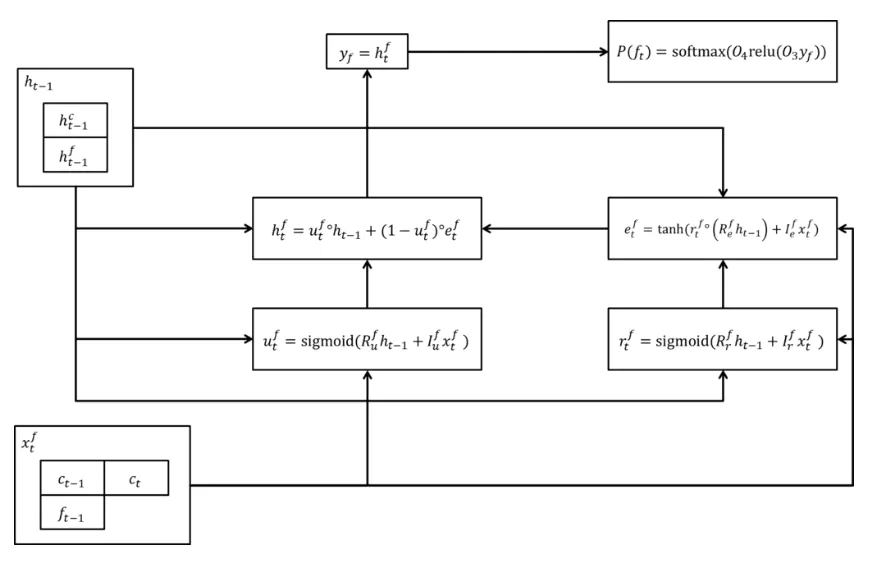

这里的计算对应语音生成效率的分析，也就是减小N的大小，上述模型把N在WaveNet中的30减到了5，生成速度可能比WaveNet快，因为WaveRNN有一个更大的N。

另一个需要考虑的问题是，如何减少参数的装载时间？

作者针对它所进行实验的GPU型号(P100)设计了hidden units的个数896，使得所有参数都可以load到GPU的寄存器中，从而大幅度减少了overhead 时间(d)，模型的速度达到了96000 samples/second。

### Sparse WaveRNN 

#### 1. Weight Sparsification Method

网络的稀疏算法有很多，本文的算法应该不是WaveRNN第一个提出的。WaveRNN使用clip方法。在训练过程中，网络中较小的值被裁剪为0.作者使用了一种随着训练进行逐渐增加稀疏程度的方法。对每个参数矩阵维护一个binary mask，开始的时候binary mask为全1，训练每进行一段时间，就对参数矩阵的元素进行排序，然后把值最小的k个元素的mask设置为0。这个k是根据稀疏性要求来确定的。他会逐渐变大，直到满足稀疏性的要求。

k的计算需要考虑我们想要的稀疏度Z和矩阵中元素的总量，我们计算一个比例z，这个z乘上参数总量就是k的值，z的计算公式如下：

$$z=Z\Big(1-\big(1-\frac{t-t_0}{S}\big)^3\Big)$$

#### 2. Structured Sparsity

我们还可以通过编码稀疏矩阵的方法来减少参数的存储消耗。

作者使用4x4 block作为单位来压缩矩阵，也就是说，原有的参数矩阵被压缩为多个4x4矩阵，这样binary mask的大小就可以缩小为原来的十六分之一，且不会损失表现。作者尝试的另一个结构是16x1 block，这种压缩方法只需要一个dot product就可以得到activation value，因此在效率上表现更好

### Subscale WaveRNN

下图为sub-scale生成过程。

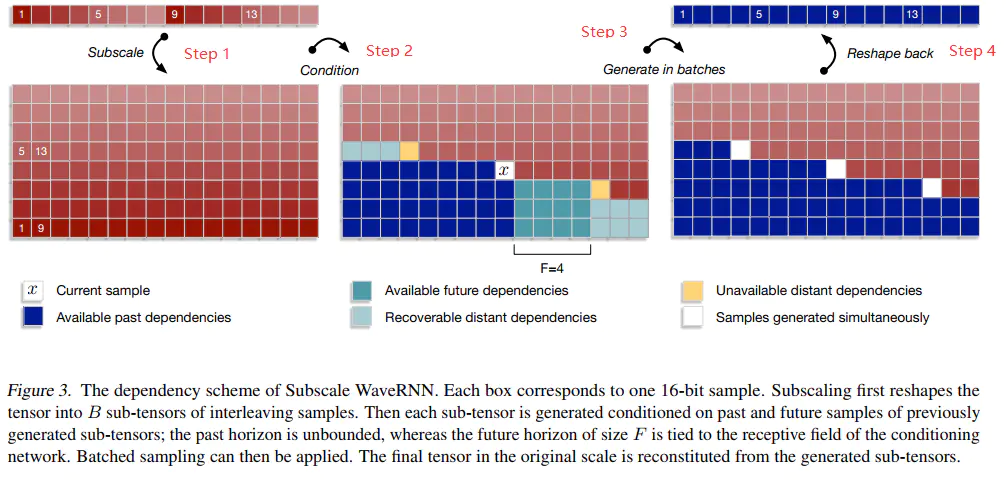

下图为解释sub-scale生成过程，横轴为时间轴

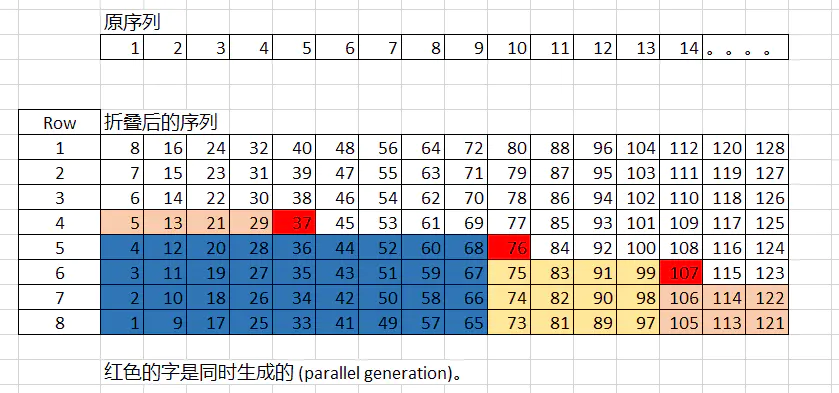

上面介绍的WaveRNN减少了N和 $d(op)$ 的大小，稀疏WaveRNN减少了 $c(op)$ 的计算量，最终减少了 $|u|$ 的大小。一种比较简单的方法是产生8bit量化的声音，但是这种声音的保真度损失很大。本文提出了sub-scale生成过程，可以通过并行线性减少生成声音所需时间，可以用一下公式表示。

$$T(u)=\frac{|u|}{B}\sum_{i=1}^N (c(op_i)^B+d(op_i)^B)$$

其中B是batch_size.当然，这并不代表时间就缩短了B倍，因为该生成的还是要生成，但是同时生成多个token可以重复利用参数，因此还是加快了速度。

这种parallel generation面临的问题就是如何切断token之间的依赖。

我们首先列出同时生成B个token时的序列的概率依赖公式:

$$P(u)=\prod_{s=0}^B \prod_{i=0}^{|u|/B} P(u_{Bi+s}|u_{Bj+s} \text{for} j<i,u_{Bk+z} \text{for} z<s \text{and} k\geq 0)$$

我们看到这个生成不是按照先后顺序生成的，前面的token也会依赖后面的token，但是作者认为，前面的token不会依赖太后面的token，即如果k > i + F，则这个依赖就没什么作用了，因此作者消除了这些依赖。

- step1: 首先将L大小的张量折叠成大小为L/B 的B个张量。
    以上图为例，原序列 1,2,...,128,折叠分成8份，每份16个长度的张量，但是折叠后得到的数组是1,9,17,25，相当于对原始序列进行了下采样，即sub-scale sampling.
    
- step2: 解释声音的产生过程和相关条件（conditions）。假设每个sub-tensor的生成需要较少的前瞻性。用上图解释，第一个生成的行是第八行，即1，9，17，25，33...数组列表。会先生成这一列数组，然后再生成第七行数组，依次生成。但是数组第七行的生成不仅要考虑当时已经生成的第八行和第七行，还要考虑未来横轴上第八行的生成。根据原论文，这里主要对第五行红色数字76的生成做解释。76的生成需要考虑当前时刻之前的所有数字，即第八行第七行第六行第五行，第1-9列蓝色标记的值，以及未来第10-13列。该值，即前瞻性是F=4.

- step3: 解释并行生成的过程。根据上图，红色标记的37,76,107可以同时并行生成。就像step2一样，前瞻性F=4.

- step4: 最后一步是将生成的矩阵展开成原来的序列，1,2,3...这样就达到了高度并行和快速语音生成的目的。
    根据上图的解释，如果要产生24kHz的声音，，如果B=16，则sub-scale生成速度为 24/16=1.5kHz.
    
模型复现：https://github.com/fatchord/WaveRNN

## LPCNet

'pure neuron(纯神经元)'计算量大的原因之一是神经元必须完成所有工作。他们不仅要生成合理的声门脉冲，而且还必须模拟声道中的滤波器。使用70年的数字信号处理进行滤波很容易，但是对于神经网络来说实际上很难做到。这是因为滤波器所需的DSP操作不能很好的映射到神经网络。首先，从频谱计算预测系数本质上需要求解线性方程。有高效的DSP算法可以做到这点(eg:Levinson-Durbin)但你不能仅用几层神经网络就实现等效算法。即使使用过滤器本身--一个线性操作--doesn't map well with the WaveNet or WaveRNN architectures. 这是因为滤波器包含将不同的输入相乘，而神经网络通常会计算输入的线性组合，输入之间没有乘法项。当然我们可以唱见一个能够学习滤波器的强壮架构，在这一点上我们为什么不直接添加一些DSP模块来直接帮助神经网络呢？

LPCNet由此产生。LPCNet 是WaveRNN的变体，对WaveRNN做了一些改进，其中最重要的是添加了明确的LPC 滤波器。是一个 数字信号处理（DSP） 和 神经网络（NN）巧妙结合应用于语音合成中 vocoder 的工作，可以在普通的CPU上实时合成高质量语音。传统上，基于 DSP 的 vocoder 速度很快，但是合成的语音质量不是太好，而基于 NN 的 vocoder 语音质量更高，但通常复杂度太高，无法实时。因此他以 WaveRNN 为基础显式加入 LPC filter 模块来降低神经网络部分的复杂度。一个直觉的想法是 WaveRNN 需要为整个采样值建模，那么如果我将这个采样值分解成线性和非线性两部分，线性部分通过基于 DSP 的线性预测给出，神经网络仅需建模变化相对较小的非线性残余部分，这会是个更简单的任务，更少的神经元便可以胜任。 下面我们将详细分析 LPCNet 的细节。代替仅仅给RNN选择的样本，我们也给了即将选择的下一个样本的预测(即估计)。这个预测不一定是完美的也不会包含随机成分，但是它计算起来非常便宜，最终会代替许多神经元。我们还可以让网络预测下一个样本和这个预测的差异，又名excitation.现在我们的网络不再努力为声道建模（尽管他可以解决预测的任何问题）

LPCNet 的主体网络结构如下图所示，这里忽略了 pcm 到 μ-law 的编码转换。因为特征提取以帧 (10ms, 160 样点）为单位进行，而语音生成是以样点为单位进行，因此 LPCNet 网络可以分解为两个子网络: Frame rate network 和 Sample rate network，外加一个计算 LPC 的模块。

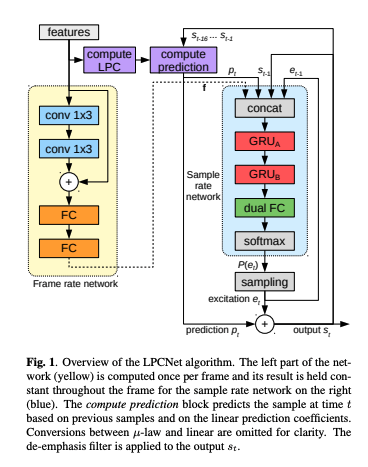

网络分成两部分，从语音提取特征的frame-rate network，输入（10ms,160样点）提取到 embedding 之后，语音合成只基于样点进行的，在sample-rate network中进行。

### 数据准备和训练

网络使用 CrossEntropy 准则训练， 在 softmax 位置评估预测 $e_t$ 分布和真实分布的交叉熵。测试时输入仅包含 features，训练时输入还包含 $p_t,s_{t-1},e_{t-1}$ ，输出参考为 $e_t$ 。这部分数据准备使用了原始语音 $s_t$ , 利用 features 计算出来的 LPC 产生线性预测 $p_t$ , 而 $e_t=s_t - p_t$ 既是输入（延时）也是输出参考。

除了线性预测，LPCNet还包括一些其他技巧：

- 预加重/去加重滤波器：允许使用$\mu-law$量化对噪声进行整形。

- 稀疏矩阵：与WaveRNN一样，LPCNet在主要的RNN上使用了稀疏矩阵，仅保留10%的权重（其他权重为0），这些矩阵是块稀疏的，块大小为16\*1,以便在乘法中更容易向量化。一个小的改进是，矩阵对角线上的权重都被保留

- Input Embedding:我们没有直接将输入喂给网络而是使用了embedding matrix.在进行自然语言处理时，embedding常用于单词，但将其用$\mu-law$值可以学习输入的非线性函数。有趣的事，当查看学习到的embedding时，其中一个函数非常接近$\mu-law$ 扩展(解码)函数